In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import SimpleITK as sitk
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    RandFlipd,
    Spacingd,
    CenterSpatialCropd,
    LoadImaged,
    ScaleIntensityRanged,
    EnsureTyped,
    Lambdad,
)
from monai.utils import set_determinism, first
#from networks.add_net.SpatiaAttention_unet import Unet256Generator
#from networks.add_net.discriminator import ConditionalDiscriminator2
#from monai.networks.nets import AttentionUnet, SwinUNETR,UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
import torch.nn.utils.spectral_norm as spectral_norm
import random
from torch.amp import GradScaler, autocast
import nibabel as nib
from net.generator import AttentionUnet

In [2]:
class BasicBlock(nn.Module):
    """Basic block with residual connection"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, norm=True, use_spectral_norm=False):
        super().__init__()
        
        # Main convolutional path
        self.conv = nn.Conv2d(inplanes, outplanes, kernel_size, stride, padding)
        if use_spectral_norm:
            self.conv = spectral_norm(self.conv)
        
        # Optional normalization
        self.isn = nn.InstanceNorm2d(outplanes) if norm else None
        
        # Activation
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        
        # Residual connection
        if stride != 1 or inplanes != outplanes:
            self.residual = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0)
            if use_spectral_norm:
                self.residual = spectral_norm(self.residual)
        else:
            self.residual = nn.Identity()
        
    def forward(self, x):
        # Main path
        fx = self.conv(x)
        if self.isn is not None:
            fx = self.isn(fx)
        fx = self.lrelu(fx)
        
        # Residual path
        residual = self.residual(x)
        
        # Combine
        out = fx + residual
        return out

class ConditionalDiscriminator2(nn.Module):
    """Conditional Discriminator with Residual Connections"""
    def __init__(self):
        super().__init__()
        self.block1 = BasicBlock(6, 64, norm=False, use_spectral_norm=True)   # Output: 64 x 128 x 128
        self.block2 = BasicBlock(64, 128, use_spectral_norm=True)            # Output: 128 x 64 x 64
        self.block3 = BasicBlock(128, 256, use_spectral_norm=True)           # Output: 256 x 32 x 32
        self.block4 = spectral_norm(nn.Conv2d(256, 3, kernel_size=4, stride=1, padding=1))  # Output: 1 x 32 x 32
    def forward(self, x, cond):
        """
        Args:
            x: Input image tensor
            cond: Conditional tensor
        """
        x = torch.cat([x, cond], dim=1)  # Concatenate input and condition along channel dimension
        fx = self.block1(x)
        fx = self.block2(fx)
        fx = self.block3(fx)
        fx = self.block4(fx)
        return fx

# 定义 BasicBlock，添加 Spectral Normalization
class BasicBlock(nn.Module):
    """Basic block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, norm=True, use_spectral_norm=False):
        super().__init__()
        # 添加 Spectral Normalization
        self.conv = nn.Conv2d(inplanes, outplanes, kernel_size, stride, padding)
        if use_spectral_norm:
            self.conv = spectral_norm(self.conv)
        
        self.isn = None
        if norm:
            self.isn = nn.InstanceNorm2d(outplanes)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        fx = self.conv(x)
        if self.isn is not None:
            fx = self.isn(fx)
        fx = self.lrelu(fx)
        return fx

# 定义 ConditionalDiscriminator2，添加 Spectral Normalization
class ConditionalDiscriminator2(nn.Module):
    """Conditional Discriminator"""
    def __init__(self):
        super().__init__()
        self.block1 = BasicBlock(2, 64, norm=False, use_spectral_norm=True)  # 64 * 128 * 128
        self.block2 = BasicBlock(64, 128, use_spectral_norm=True)           # 128 * 64 * 64
        self.block3 = BasicBlock(128, 256, use_spectral_norm=True)          # 256 * 32 * 32
        self.block4 = spectral_norm(nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1))  # 1 * 32 * 32# 对最后一层添加 Spectral Normalization
        self.dropout = nn.Dropout(0.2)  # 添加 Dropout 层

    def forward(self, x, cond):
        """
        Args:
            x: 输入图像张量
            cond: 条件张量
        """
        x = torch.cat([x, cond], dim=1)  # 拼接输入和条件
        fx = self.block1(x)
        fx = self.block2(fx)
        fx = self.block3(fx)
        fx = self.block4(fx)
        fx = self.dropout(fx)  # 添加 Dropout
        return fx

In [3]:
torch.__version__
set_determinism(seed=42)

In [4]:
imgs_path = sorted(glob.glob('E:/pytorch/CTsan2artery/image2reconstruction/convention_nifti2d/*/*.nii.gz'))

In [5]:
len(imgs_path)

34115

In [6]:
annos_path = sorted(glob.glob('E:/pytorch/CTsan2artery/image2reconstruction/VNC_nifti_2d/*/*.nii.gz'))

In [7]:
len(annos_path)

34115

In [8]:
imgs_path[:3], annos_path[:3]

(['E:/pytorch/CTsan2artery/image2reconstruction/convention_nifti2d\\BaiXiaoBin_94647046_20190708\\slice_BaiXiaoBin_94647046_20190708_100_3.nii.gz',
  'E:/pytorch/CTsan2artery/image2reconstruction/convention_nifti2d\\BaiXiaoBin_94647046_20190708\\slice_BaiXiaoBin_94647046_20190708_101_3.nii.gz',
  'E:/pytorch/CTsan2artery/image2reconstruction/convention_nifti2d\\BaiXiaoBin_94647046_20190708\\slice_BaiXiaoBin_94647046_20190708_102_3.nii.gz'],
 ['E:/pytorch/CTsan2artery/image2reconstruction/VNC_nifti_2d\\BaiXiaoBin_94647046_20190708\\slice_BaiXiaoBin_94647046_20190708_100_3.nii.gz',
  'E:/pytorch/CTsan2artery/image2reconstruction/VNC_nifti_2d\\BaiXiaoBin_94647046_20190708\\slice_BaiXiaoBin_94647046_20190708_101_3.nii.gz',
  'E:/pytorch/CTsan2artery/image2reconstruction/VNC_nifti_2d\\BaiXiaoBin_94647046_20190708\\slice_BaiXiaoBin_94647046_20190708_102_3.nii.gz'])

(1, 3, 275, 275)
(1, 3, 275, 275)
(1, 3, 275, 275)
(1, 3, 275, 275)


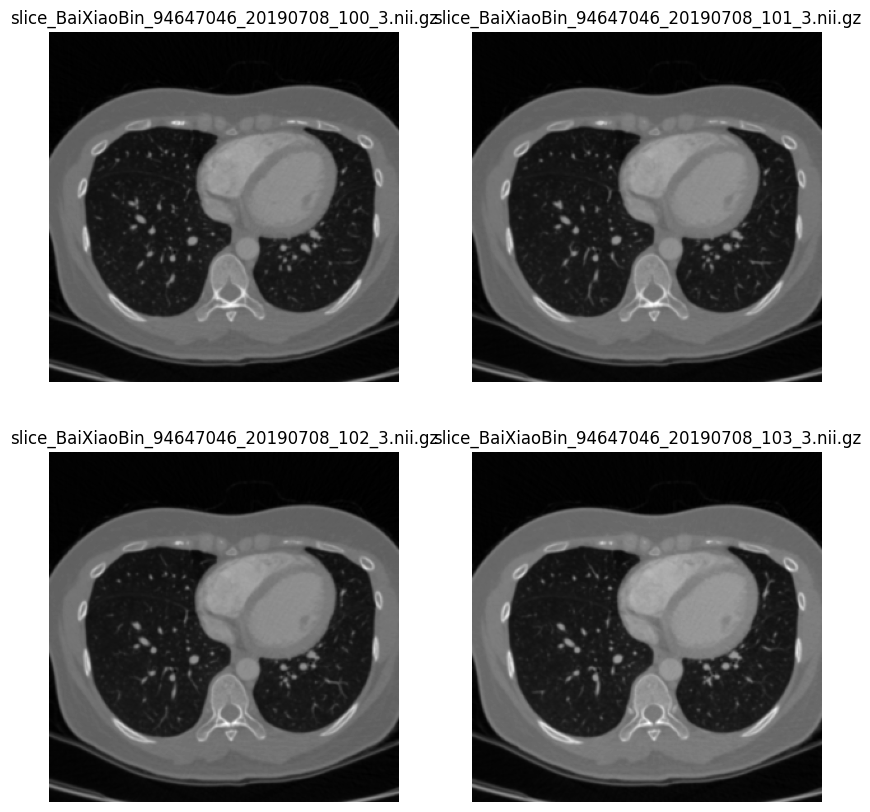

In [9]:
plt.figure(figsize=(10,10))
for i, img_path in enumerate(imgs_path[:4]):
    img = sitk.ReadImage(img_path)
    img_np = sitk.GetArrayFromImage(img)
    img_np = np.expand_dims(img_np, axis=0)
    print(img_np.shape)
    plt.subplot(2,2,i+1)
    plt.imshow(img_np[0,1,:,:], cmap='gray')
    plt.title(img_path.split('\\')[-1])
    plt.axis('off')

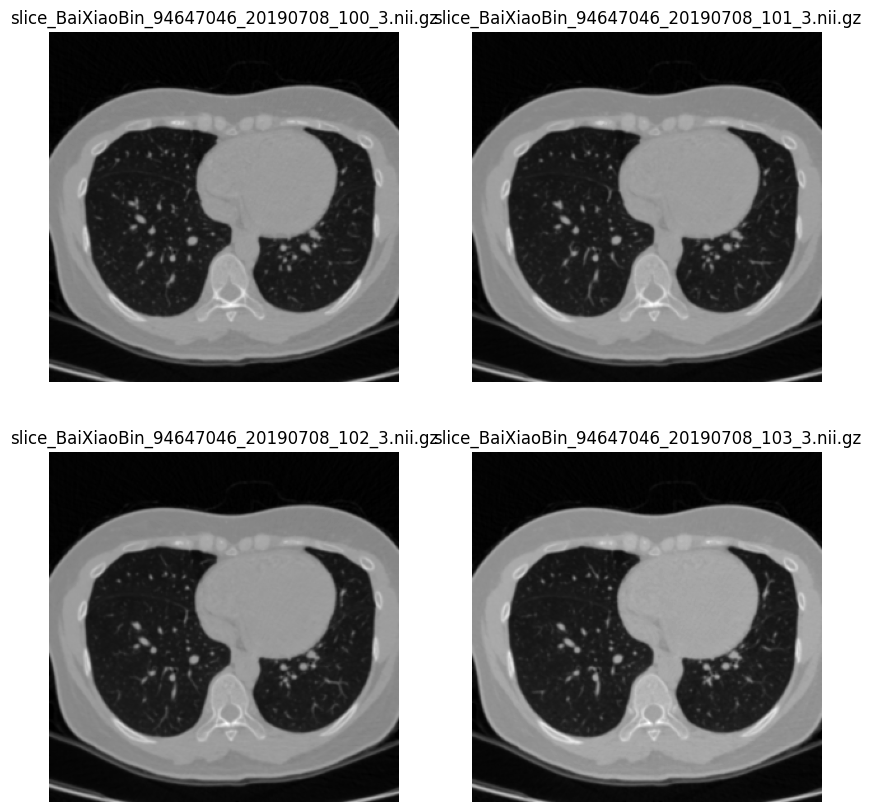

In [10]:
plt.figure(figsize=(10,10))
for i, img_path in enumerate(annos_path[:4]):
    img = sitk.ReadImage(img_path)
    img_np = sitk.GetArrayFromImage(img)
    img_np = np.expand_dims(img_np, axis=0)
    plt.subplot(2,2,i+1)
    plt.imshow(img_np[0,1,:,:], cmap='gray')
    plt.title(img_path.split('\\')[-1])
    plt.axis('off')

In [11]:
data_dicts = [
    {"anno": image_name, "img": idone_name}
    for image_name, idone_name in zip(annos_path, imgs_path)
]

In [12]:
random.shuffle(data_dicts)
# 计算切分点
split_point = int(len(data_dicts) * 0.8)

In [13]:
train_files, val_files = data_dicts[:split_point], data_dicts[split_point:]

In [14]:
train_transforms = Compose(
    [
        LoadImaged(keys=["anno", "img"]),
        EnsureChannelFirstd(keys=["anno", "img"]),
    #    EnsureTyped(keys=["anno", "img"]),
    #    Spacingd(keys=["anno", "img"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "bilinear",)),
        ScaleIntensityRanged(
            keys=["anno","img"], a_min=-1000, a_max=1000,
            b_min=-1.0, b_max=1.0, clip=True,
        ),
        CenterSpatialCropd(keys=["anno", "img"], roi_size=(256, 256,3)),
        RandFlipd(keys=["anno", "img"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["anno", "img"], prob=0.5, spatial_axis=1), 
        # 使用 Lambda 转换调整通道顺序，确保输出为 [3, 256, 256]
        Lambdad(keys=["anno", "img"], func=lambda x: x.permute(0, 3, 1, 2).squeeze()) # 使用 Lambda 转换调整通道顺序，确保输出为 [3, 256, 256]
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["anno", "img"]),
        EnsureChannelFirstd(keys=["anno", "img"]),
    #    EnsureTyped(keys=["anno", "img"]),
    #    Spacingd(keys=["anno", "img"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "bilinear",)),
        ScaleIntensityRanged(
            keys=["anno", "img"], a_min=-1000, a_max=1000,
            b_min=-1.0, b_max=1.0, clip=True,
        ),
        CenterSpatialCropd(keys=["anno", "img"], roi_size=(256, 256,3)),
        # 使用 Lambda 转换调整通道顺序，确保输出为 [3, 256, 256]
        Lambdad(keys=["anno", "img"], func=lambda x: x.permute(0, 3, 1, 2).squeeze())
    ]
)

In [15]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["anno"][0], check_data["img"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

image shape: torch.Size([3, 256, 256]), label shape: torch.Size([3, 256, 256])


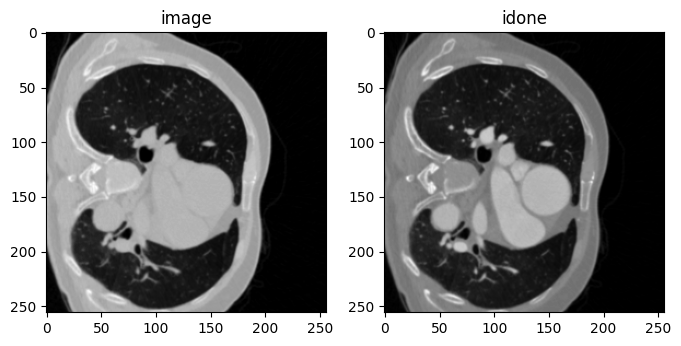

In [16]:
plt.figure("visualize", (8, 8))
plt.subplot(2, 2, 1)
plt.title("image")
plt.imshow(image[1, :,:], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("idone")
plt.imshow(label[1, :,:],cmap='gray')
plt.show()

image shape: torch.Size([3, 256, 256]), label shape: torch.Size([3, 256, 256])


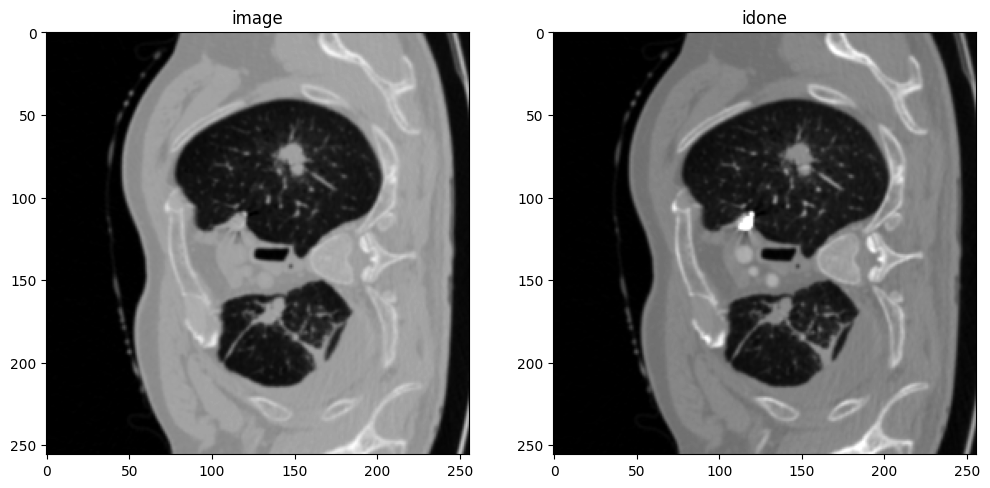

In [17]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["anno"][0], check_data["img"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 60]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[1,:, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("idone")
plt.imshow(label[1,:, :],cmap="gray")
plt.show()

In [18]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
#train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=40, shuffle=True, num_workers=0, drop_last = True)
val_ds = CacheDataset( data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0, )
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0,shuffle=False,drop_last = True)

Loading dataset: 100%|██████████| 6823/6823 [02:03<00:00, 55.08it/s]


In [19]:
val_ds = CacheDataset( data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0,shuffle=False,drop_last = True)

Loading dataset: 100%|██████████| 6823/6823 [01:54<00:00, 59.62it/s]


In [20]:
# 数据迭代示例
for i,batch in enumerate(train_loader):
    img_tensor = batch["img"]
    anno_tensor = batch["anno"]
    print(f"Image shape: {img_tensor.shape}, Annotation shape: {anno_tensor.shape}")
    break

Image shape: torch.Size([40, 3, 256, 256]), Annotation shape: torch.Size([40, 3, 256, 256])


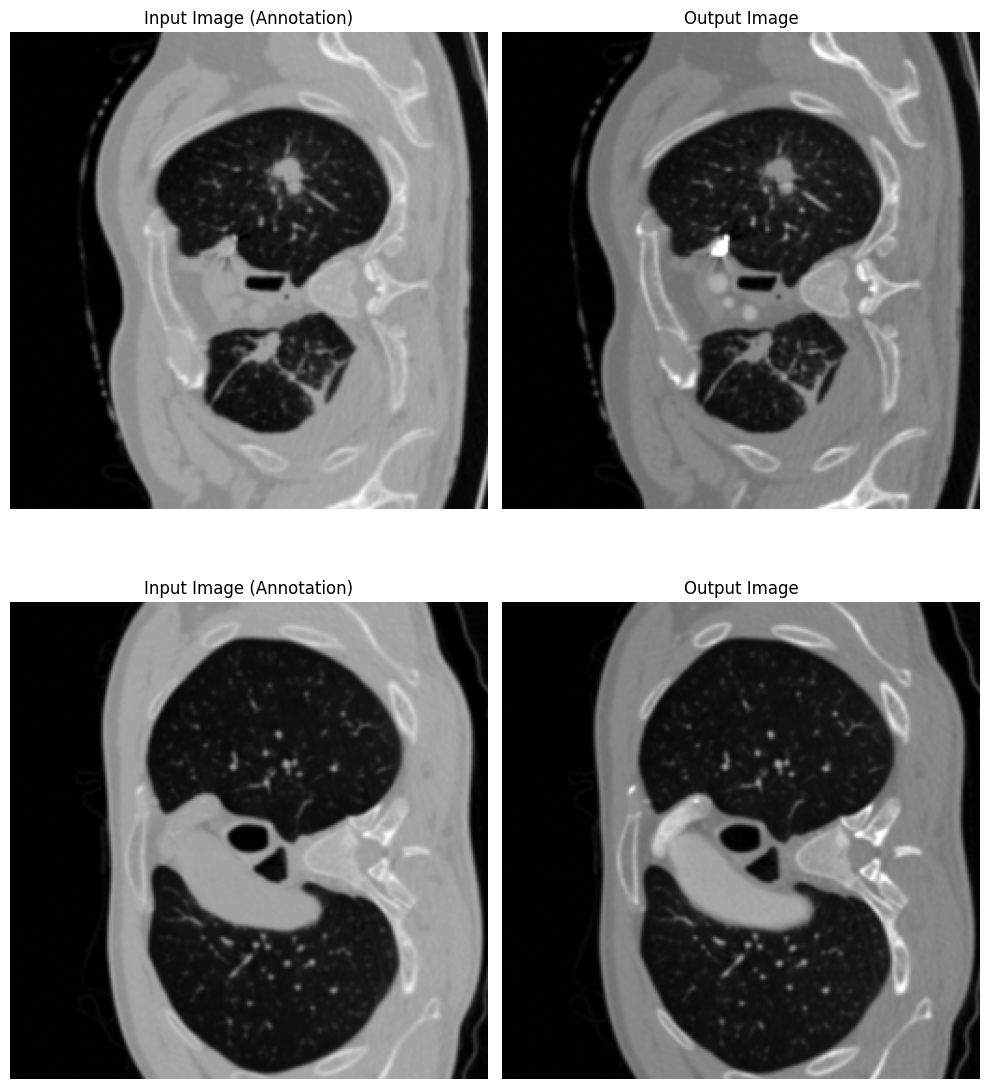

In [21]:
# 设置画布大小
plt.figure(figsize=(10, 12))

# 遍历测试集的第 4 个 batch
for i, batch in enumerate(val_loader):  # 遍历 test_loader
    if i >= 2:  # 最多显示 2 组数据（从第 2 个 batch 开始）
        break
    
    # 提取 anno 和 img 数据
    anno = batch["anno"].numpy()
    img = batch["img"].numpy()

    # 将数据归一化
    anno = (anno[0] + 1) / 2  # 假设 batch 维度是第一维度
    img = (img[0] + 1) / 2

    # 可视化处理
    plt.subplot(2, 2, 2 * i + 1)  # 总共 8 个子图
    plt.imshow(anno[1, :, :], cmap='gray')  # anno[0, :, :] 是取出第 0 个通道（如果有多个通道）
    plt.title('Input Image (Annotation)')
    plt.axis('off')

    plt.subplot(2, 2, 2 * i + 2)
    plt.imshow(img[1, :, :], cmap='gray')  # img[0, :, :] 是取出第 0 个通道（如果有多个通道）
    plt.title('Output Image')
    plt.axis('off')

# 显示图像
plt.tight_layout()
plt.show()

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#gen = Unet256Generator().to(device)
gen = AttentionUnet(spatial_dims=2, in_channels=3, out_channels=3, channels=(64,128,256,512,1024,1024), strides=(2,2,2,2,2,2)).to(device) # 跟图像其实没有关系
#gen = SwinUNETR(img_shape=(256, 256), in_channels=1, out_channels=1,).to(device)
#gen = UNet(spatial_dims=2,in_channels=1,out_channels=1,channels=(64,128,256,512,512),strides=(2,2,2,2,2),num_res_units=2).to(device)
dis = ConditionalDiscriminator2().to(device)
loss_fn = nn.BCEWithLogitsLoss()
dis_optimizer = optim.AdamW(dis.parameters(), lr=0.0001, betas=(0.5, 0.999))
gen_optimizer = optim.AdamW(gen.parameters(), lr=0.0005, betas=(0.5, 0.999))
#gen = torch.nn.DataParallel(gen, device_ids=[0,1])
# 创建学习率调度器
# 定义学习率调度器
gen_scheduler = optim.lr_scheduler.CosineAnnealingLR(gen_optimizer, T_max=50, eta_min=0.0001)
dis_scheduler = optim.lr_scheduler.CosineAnnealingLR(dis_optimizer, T_max=50, eta_min=0.00001)
#ReduceLROnPlateau 是一种常用的学习率调度器，它会在损失不再下降时降低学习率。具体参数包括：mode：'min' 表示监控损失是否下降，'max' 表示监控指标是否上升。factor：学习率降低的因子（例如 0.5 表示学习率减半）。
#patience：等待多少个 epoch 后如果损失没有下降，则降低学习率。verbose：是否打印学习率更新的信息。

import netron
import torch.onnx
input = torch.rand(1,1,256,256).to(device)
output = gen(input)
onnx_path = "netForwatch.onnx"
torch.onnx.export(gen, input, onnx_path,export_params=True,opset_version=11) #输入可视化模型

In [23]:
def set_window(image_array):
    image_array = image_array.astype(np.float32)
    image_array = -1000 + 1000 * (image_array - image_array.min())
    return image_array

In [24]:
def generater_images(model, test_input, true_traget):
    prediction = model(test_input).permute(0,2,3,1).detach().cpu().numpy()
    prediction = (prediction + 1)/2
    test_input = test_input.permute(0,2,3,1).detach().cpu().numpy()
    true_traget = true_traget.permute(0,2,3,1).detach().cpu().numpy()
    plt.figure(figsize=(15,15))
    display_list = [test_input[0], true_traget[0], prediction[0]]
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [25]:
for batch in val_loader:
    annos_batch = batch["anno"].to(device)  # 从 batch 中提取 "anno"
    imgs_batch = batch["img"].to(device)    # 从 batch 中提取 "img"
    break  # 只取第一个 batch，之后停止迭代

In [26]:
# 定义梯度检查函数
def check_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [27]:
def save_to_nii(data, filename):
    """
    保存 3D 数据为 nii.gz 文件
    Args:
        data: 3D numpy 数组，形状为 [D, H, W]
        filename: 保存的文件路径，例如 "output/prediction.nii.gz"
    """
    # 创建一个 NIfTI 图像
    nii_img = nib.Nifti1Image(data, affine=np.eye(4))
    # 保存到文件
    nib.save(nii_img, filename)

In [28]:
def generate_and_save_nii(model, test_input, true_target, output_dir, epoch):
    """
    处理 4D 张量并保存为 2D 图像
    """
    # 定义反归一化范围
    min_value, max_value = -990, 3071

    # 创建三个子目录
    input_dir = os.path.join(output_dir, "test_input")
    target_dir = os.path.join(output_dir, "true_target")
    prediction_dir = os.path.join(output_dir, "prediction")

    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(target_dir, exist_ok=True)
    os.makedirs(prediction_dir, exist_ok=True)

    # 模型预测
    prediction = model(test_input).detach().cpu().numpy()  # 转换为 [B, C, H, W]
    prediction = (prediction + 1) / 2 * (max_value - min_value) + min_value  # 反归一化到 [-990, 3071]

    # 输入和目标数据的转换
    test_input = test_input.detach().cpu().numpy()  # [B, C, H, W]
    test_input = (test_input + 1) / 2 * (max_value - min_value) + min_value  # 反归一化

    true_target = true_target.detach().cpu().numpy()  # [B, C, H, W]
    true_target = (true_target + 1) / 2 * (max_value - min_value) + min_value  # 反归一化

    # 保存 batch 第一张样本的第一个通道
    input_slice_path = os.path.join(input_dir, f"test_input_epoch_{epoch}_first_slice.nii.gz")
    save_to_nii(test_input[0, :, :, :], input_slice_path)

    target_slice_path = os.path.join(target_dir, f"true_target_epoch_{epoch}_first_slice.nii.gz")
    save_to_nii(true_target[0, :, :, :], target_slice_path)

    prediction_slice_path = os.path.join(prediction_dir, f"prediction_epoch_{epoch}_first_slice.nii.gz")
    save_to_nii(prediction[0, :, :, :], prediction_slice_path)

    print(f"First slice of first sample for epoch {epoch} saved in NIfTI format:")
    print(f"  - Test input: {input_slice_path}")
    print(f"  - True target: {target_slice_path}")
    print(f"  - Prediction: {prediction_slice_path}")

In [29]:
plan_image_save_path = 'E:/pytorch/CTsan2artery/plan_save_25'
if not os.path.exists(plan_image_save_path):
    os.makedirs(plan_image_save_path)
    
predict_save_path = 'E:/pytorch/CTsan2artery/predict_save_25'
artery_save_path = 'E:/pytorch/CTsan2arterynoise_save_25'
if not os.path.exists(predict_save_path):
    os.makedirs(predict_save_path)

output_plot = 'E:/pytorch/CTsan2artery/output_save_25'  # 保存绘制曲线。
if not os.path.exists(output_plot):
    os.makedirs(output_plot)
if not os.path.exists(artery_save_path):
    os.makedirs(artery_save_path)

clean_targets = True
ckpt_save_path = 'E:/pytorch/CTsan2artery/checkpoints_25'  # 保存检查点的路径
if not os.path.exists(ckpt_save_path):
    os.makedirs(ckpt_save_path)
ckpt_overwrite = False

In [30]:
import pandas as pd

# 检查是否存在已保存的模型用于断点续训
checkpoint_path = "checkpoint.pth"  # 定义断点续训的检查点路径
start_epoch = 0  # 初始 epoch

if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    gen.load_state_dict(checkpoint["gen_state_dict"])
    dis.load_state_dict(checkpoint["dis_state_dict"])
    gen_optimizer.load_state_dict(checkpoint["gen_optimizer_state_dict"])
    dis_optimizer.load_state_dict(checkpoint["dis_optimizer_state_dict"])
    gen_scheduler.load_state_dict(checkpoint["gen_scheduler_state_dict"])
    dis_scheduler.load_state_dict(checkpoint["dis_scheduler_state_dict"])
    D_loss = checkpoint["D_loss"]
    G_loss = checkpoint["G_loss"]
    start_epoch = checkpoint["epoch"] + 1  # 恢复的起始 epoch
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")

# 初始化存储损失值的 DataFrame
loss_data = pd.DataFrame(columns=["Epoch", "D_loss", "G_loss"])

# 定义损失缩放器
scaler = GradScaler()

# 训练循环
LAMBDA = 10
D_loss = []
G_loss = []
#使用Hinge损失
for epoch in range(200):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_loader)
    
    for step, batch in enumerate(train_loader):
        imgs = batch["img"].to(device)
        annos = batch["anno"].to(device)
        
        # 判别器更新
        for p in dis.parameters(): 
            p.data.clamp_(-0.2, 0.2)  # 限制参数值在 [-0.2, 0.2]
        dis_optimizer.zero_grad()

        # 使用混合精度计算判别器损失
        with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
            # 判别器对真实图片的输出
            dis_real_output = dis(annos, imgs)
            dis_real_loss = torch.mean(torch.relu(1 - dis_real_output))  # 真实样本的 Hinge 损失

            # 生成器生成的假图片
            gen_output = gen(annos)
            
            # 判别器对生成图片的输出
            dis_fake_output = dis(annos, gen_output.detach())
            dis_fake_loss = torch.mean(torch.relu(1 + dis_fake_output))  # 生成样本的 Hinge 损失

            # 总判别器损失
            dis_loss = dis_real_loss + dis_fake_loss

        # 反向传播并更新判别器
        scaler.scale(dis_loss).backward()
        scaler.step(dis_optimizer)
        scaler.update()

        # 更新生成器的次数判断
        gen_updates = 3 if epoch < 50 else 1

        # 更新生成器
        for gen_update in range(gen_updates):
            gen_optimizer.zero_grad()

            # 使用混合精度计算生成器损失
            with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                gen_output = gen(annos)  # 重新生成假图片
                dis_gen_output = dis(annos, gen_output)  # 判别器对生成图片的输出
                gen_loss = -torch.mean(dis_gen_output)  # 生成器的 Hinge 损失

                # 添加 L1 损失（可选）
                gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))  # L1 损失
                gen_loss += LAMBDA * gen_loss_L1  # 总生成器损失

            # 反向传播并更新生成器
            scaler.scale(gen_loss).backward()
            scaler.step(gen_optimizer)
            scaler.update()

        # 记录损失
        with torch.no_grad():
            D_epoch_loss += dis_loss.item()
            G_epoch_loss += gen_loss.item()
    
    # 每个epoch的平均损失
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        # 将新行添加到 DataFrame
        new_row = pd.DataFrame({"Epoch": [epoch], "D_loss": [D_epoch_loss], "G_loss": [G_epoch_loss]})
        loss_data = pd.concat([loss_data, new_row], ignore_index=True)

        # 保存到 CSV 文件
        loss_data.to_csv("loss_data.csv", index=False)
        # 更新学习率
        gen_scheduler.step()  # 根据生成器损失更新学习率
        dis_scheduler.step()  # 根据判别器损失更新学习率

        if epoch % 2 == 0:
            print(f'Epoch [{epoch}/200], D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}')
            
            # 生成可视化图像
            generate_and_save_nii(gen, annos, imgs, output_dir=predict_save_path, epoch=epoch)
            plt.figure(figsize=(8, 6))
            plt.plot(D_loss, label='D_loss')
            plt.plot(G_loss, label='G_loss')
            plt.legend()
            plt.title("Loss Curve")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            
            # 保存图像到文件夹，文件名包含 epoch
            output_path = os.path.join(output_plot, f"loss_curve_epoch_{epoch}.png")
            plt.savefig(output_path, dpi=300)  # 保存图像，分辨率 dpi=300
            plt.close()  # 关闭图像，避免内存泄漏
            # 保存模型
            torch.save(gen.state_dict(), f"saved_2.5Dmodels/gen_{epoch}.pth")
    
    # 保存断点续训的检查点
    if epoch % 50 == 0:
        torch.save(
            {
                "epoch": epoch,
                "gen_state_dict": gen.state_dict(),
                "dis_state_dict": dis.state_dict(),
                "gen_optimizer_state_dict": gen_optimizer.state_dict(),
                "dis_optimizer_state_dict": dis_optimizer.state_dict(),
                "gen_scheduler_state_dict": gen_scheduler.state_dict(),
                "dis_scheduler_state_dict": dis_scheduler.state_dict(),
                "D_loss": D_loss,
                "G_loss": G_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved at epoch {epoch}.")

KeyboardInterrupt: 

In [ ]:
import pandas as pd 
# 检查是否存在已保存的模型用于断点续训
checkpoint_path = "checkpoint.pth"  # 定义断点续训的检查点路径
start_epoch = 0  # 初始 epoch

if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    gen.load_state_dict(checkpoint["gen_state_dict"])
    dis.load_state_dict(checkpoint["dis_state_dict"])
    gen_optimizer.load_state_dict(checkpoint["gen_optimizer_state_dict"])
    dis_optimizer.load_state_dict(checkpoint["dis_optimizer_state_dict"])
    gen_scheduler.load_state_dict(checkpoint["gen_scheduler_state_dict"])
    dis_scheduler.load_state_dict(checkpoint["dis_scheduler_state_dict"])
    D_loss = checkpoint["D_loss"]
    G_loss = checkpoint["G_loss"]
    start_epoch = checkpoint["epoch"] + 1  # 恢复的起始 epoch
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")
# 初始化存储损失值的 DataFrame
loss_data = pd.DataFrame(columns=["Epoch", "D_loss", "G_loss"])

# 定义损失缩放器
scaler = GradScaler()

# 训练循环
LAMBDA = 10
D_loss = []
G_loss = []

for epoch in range(100):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_loader)
    
    for step, batch in enumerate(train_loader):
        imgs = batch["img"].to(device)
        annos = batch["anno"].to(device)
        
        # 判别器更新
        for p in dis.parameters(): 
            p.data.clamp_(-0.1, 0.1)  # 限制参数值在 [-0.1, 0.1]
        dis_optimizer.zero_grad()

        # 使用混合精度计算判别器损失
        with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
            dis_real_output = dis(annos, imgs)  # 判别器对真实图片的输出
            dis_real_loss = loss_fn(dis_real_output, torch.ones_like(dis_real_output, device=device))  # 真实图片的损失

            # 生成器生成的假图片
            gen_output = gen(annos)
            
            # 判别器对生成图片的输出
            dis_fake_output = dis(annos, gen_output.detach())
            dis_fake_loss = loss_fn(dis_fake_output, torch.zeros_like(dis_fake_output, device=device))  # 假图片的损失

            # 总判别器损失
            dis_loss = dis_real_loss + dis_fake_loss

        # 反向传播并更新判别器
        scaler.scale(dis_loss).backward()
        scaler.step(dis_optimizer)
        scaler.update()

        # 检查判别器的梯度大小
#        dis_grad_norm = check_gradients(dis)
#        print(f"Step [{step}/{len(train_loader)}], Discriminator Gradient Norm: {dis_grad_norm:.4f}")

        # 更新生成器 3 次
        for gen_update in range(3):
            gen_optimizer.zero_grad()

            # 使用混合精度计算生成器损失
            with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                gen_output = gen(annos)  # 重新生成假图片
                dis_gen_output = dis(annos, gen_output)  # 判别器对生成图片的输出
                gen_loss_cross_entropy = loss_fn(dis_gen_output, torch.ones_like(dis_gen_output, device=device))  # 生成器交叉熵损失
                gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))  # L1损失
                gen_loss = gen_loss_cross_entropy + (LAMBDA * gen_loss_L1)

            # 反向传播并更新生成器
            scaler.scale(gen_loss).backward()
            scaler.step(gen_optimizer)
            scaler.update()

            # 检查生成器的梯度大小
#            gen_grad_norm = check_gradients(gen)
#            print(f"Step [{step}/{len(train_loader)}], Generator Update [{gen_update + 1}/5], Gradient Norm: {gen_grad_norm:.4f}")

        # 记录损失
        with torch.no_grad():
            D_epoch_loss += dis_loss.item()
            G_epoch_loss += gen_loss.item()
    
    # 每个epoch的平均损失
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        # 将新行添加到 DataFrame
        new_row = pd.DataFrame({"Epoch": [epoch], "D_loss": [D_epoch_loss], "G_loss": [G_epoch_loss]})
        loss_data = pd.concat([loss_data, new_row], ignore_index=True)

        # 保存到 CSV 文件
        loss_data.to_csv("loss_data.csv", index=False)
        # 更新学习率
        gen_scheduler.step()  # 根据生成器损失更新学习率
        dis_scheduler.step()  # 根据判别器损失更新学习率

        if epoch % 2 == 0:
            print(f'Epoch [{epoch}/100], D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}')
            
            # 生成可视化图像
            generate_and_save_nii(gen, annos, imgs, output_dir=predict_save_path, epoch=epoch)
            plt.figure(figsize=(8, 6))
            plt.plot(D_loss, label='D_loss')
            plt.plot(G_loss, label='G_loss')
            plt.legend()
            plt.title("Loss Curve")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            
            # 保存图像到文件夹，文件名包含 epoch
            output_path = os.path.join(output_plot, f"loss_curve_epoch_{epoch}.png")
            plt.savefig(output_path, dpi=300)  # 保存图像，分辨率 dpi=300
            plt.close()  # 关闭图像，避免内存泄漏
            # 保存模型
            torch.save(gen.state_dict(), f"saved_2.5Dmodels/gen_{epoch}.pth")
    if epoch % 50 == 0:
    # 保存断点续训的检查点
        torch.save(
            {
                "epoch": epoch,
                "gen_state_dict": gen.state_dict(),
                "dis_state_dict": dis.state_dict(),
                "gen_optimizer_state_dict": gen_optimizer.state_dict(),
                "dis_optimizer_state_dict": dis_optimizer.state_dict(),
                "gen_scheduler_state_dict": gen_scheduler.state_dict(),
                "dis_scheduler_state_dict": dis_scheduler.state_dict(),
                "D_loss": D_loss,
                "G_loss": G_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved at epoch {epoch}.")

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as skimage_psnr
from skimage.metrics import structural_similarity as skimage_ssim

def calculate_mae(img1, img2):
    """计算 MAE（Mean Absolute Error）"""
    return torch.mean(torch.abs(img1 - img2)).item()

def calculate_psnr(img1, img2):
    """计算 PSNR（Peak Signal-to-Noise Ratio）"""
    img1_np = img1.cpu().numpy()
    img2_np = img2.cpu().numpy()
    return skimage_psnr(img1_np, img2_np, data_range=2.0)

def calculate_ssim(img1, img2):
    """计算 SSIM（Structural Similarity Index）"""
    img1_np = img1.cpu().numpy()  # 转换为 NumPy 数组
    img2_np = img2.cpu().numpy()  # 转换为 NumPy 数组
    
    # 确保输入数据的形状是 (C, H, W)
    if img1_np.shape[0] != 3:  # 如果通道不在第一维
        img1_np = img1_np.transpose(1, 2, 0)  # 转换为 (H, W, C)
        img2_np = img2_np.transpose(1, 2, 0)  # 转换为 (H, W, C)
        channel_axis = -1  # 通道在最后一维
    else:
        channel_axis = 0  # 通道在第一维
    
    # 计算 SSIM
    return skimage_ssim(
        img1_np, img2_np, 
        data_range=2.0,  # 假设数据范围是 [0, 1]
        channel_axis=channel_axis,  # 指定通道轴
        win_size=7  # 默认窗口大小
    )

def calculate_batch_ssim(img1_batch, img2_batch):
    """计算批量数据的 SSIM"""
    batch_size = img1_batch.shape[0]
    total_ssim = 0.0
    
    for i in range(batch_size):
        img1 = img1_batch[i]  # 获取单张图像 (C, H, W)
        img2 = img2_batch[i]  # 获取单张图像 (C, H, W)
        total_ssim += calculate_ssim(img1, img2)
    
    return total_ssim / batch_size  # 返回平均 SSIM

In [ ]:
from tqdm import tqdm

def evaluate_model(gen, val_loader, device):
    """评估模型在验证集上的性能"""
    gen.eval()  # 将模型设置为评估模式
    total_mae, total_psnr, total_ssim = 0.0, 0.0, 0.0
    count = len(val_loader)

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            imgs = batch["img"].to(device)  # 真实图像 (B, C, H, W)
            annos = batch["anno"].to(device)  # 输入条件 (B, C, H, W)

            # 生成器生成图像
            gen_output = gen(annos)  # 生成图像 (B, C, H, W)

            # 计算指标
            total_mae += calculate_mae(imgs, gen_output)
            total_psnr += calculate_psnr(imgs, gen_output)
            total_ssim += calculate_batch_ssim(imgs, gen_output)

    # 计算平均指标
    avg_mae = total_mae / count
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    return avg_mae, avg_psnr, avg_ssim

In [ ]:
# 示例：检查一个 batch 的数据
for batch in val_loader:
    imgs = batch["img"].to(device)
    annos = batch["anno"].to(device)
    
    print("Images shape:", imgs.shape)  # 应该是 (B, 3, 256, 256)
    print("Annotations shape:", annos.shape)  # 根据实际情况检查
    break

In [ ]:
import pandas as pd
import os

# 定义模型路径和保存结果的路径
model_dir = "saved_2.5Dmodels"
output_csv = "model_evaluation_results.csv"

# 初始化结果 DataFrame
results = pd.DataFrame(columns=["Epoch", "gen_epoch", "MAE", "PSNR", "SSIM"])

# 遍历所有模型
for epoch in range(0, 100, 2):  # 假设每 2 个 epoch 保存一个模型
    model_path = os.path.join(model_dir, f"gen_{epoch}.pth")
    if not os.path.exists(model_path):
        continue

    # 打印当前处理的模型文件名
    print(f"Processing model: {os.path.basename(model_path)}")

    # 加载模型
    gen.load_state_dict(torch.load(model_path, weights_only=True))
    gen.to(device)

    # 评估模型
    mae, psnr, ssim = evaluate_model(gen, val_loader, device)

    # 打印 SSIM 值
    print(f"SSIM for {os.path.basename(model_path)}: {ssim:.4f}")

    # 保存结果
    gen_epoch = f"gen_{epoch}.pth"  # 模型文件名
    new_row = pd.DataFrame({
        "Epoch": [epoch],
        "gen_epoch": [gen_epoch],  # 添加 gen_epoch 列
        "MAE": [mae],
        "PSNR": [psnr],
        "SSIM": [ssim]
    })
    results = pd.concat([results, new_row], ignore_index=True, join='inner')

# 保存结果到 CSV 文件
results.to_csv(output_csv, index=False)
print(f"Evaluation results saved to {output_csv}.")

In [ ]:
LAMBDA = 10
D_loss = []
G_loss = []

for epoch in range(200):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_loader)
    
    for step, batch in enumerate(train_loader):
        imgs = batch["img"].to(device)
        annos = batch["anno"].to(device)
        
        # 判别器更新
        for p in dis.parameters(): 
            p.data.clamp_(-0.1, 0.1)  # 限制参数值在 [-0.1, 0.1]
        dis_optimizer.zero_grad()
        dis_real_output = dis(annos, imgs)  # 判别器对真实图片的输出

        dis_real_loss = loss_fn(dis_real_output, torch.ones_like(dis_real_output, device=device))  # 真实图片的损失
        dis_real_loss.backward()

        # 生成器生成的假图片
        gen_output = gen(annos)
        
        # 判别器对生成图片的输出
        dis_fake_output = dis(annos, gen_output.detach())  # 判别器对生成图片的输出

        dis_fake_loss = loss_fn(dis_fake_output, torch.zeros_like(dis_fake_output, device=device))  # 假图片的损失
        dis_fake_loss.backward()

        # 总判别器损失
        dis_loss = dis_real_loss + dis_fake_loss
        dis_optimizer.step()

        # 检查判别器的梯度大小
        dis_grad_norm = check_gradients(dis)
        print(f"Step [{step}/{len(train_loader)}], Discriminator Gradient Norm: {dis_grad_norm:.4f}")

        # 更新生成器 5 次
        for gen_update in range(5):
            gen_optimizer.zero_grad()
            dis_gen_output = dis(annos, gen_output)  # 判别器对生成图片的输出
            gen_loss_cross_entropy = loss_fn(dis_gen_output, torch.ones_like(dis_gen_output, device=device))  # 生成器交叉熵损失
            gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))  # L1损失
            gen_loss = gen_loss_cross_entropy + (LAMBDA * gen_loss_L1)
            gen_loss.backward()
            gen_optimizer.step()

            # 检查生成器的梯度大小
            gen_grad_norm = check_gradients(gen)
            print(f"Step [{step}/{len(train_loader)}], Generator Update [{gen_update + 1}/5], Gradient Norm: {gen_grad_norm:.4f}")

            # 更新生成器的输出（让每次生成器更新使用最新的结果）
            gen_output = gen(annos)

        # 记录损失
        with torch.no_grad():
            D_epoch_loss += dis_loss.item()
            G_epoch_loss += gen_loss.item()
    
    # 每个epoch的平均损失
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)

        # 更新学习率
        gen_scheduler.step(G_epoch_loss)  # 根据生成器损失更新学习率
        dis_scheduler.step(D_epoch_loss)  # 根据判别器损失更新学习率

        if epoch % 2 == 0:
            print(f'Epoch [{epoch}/200], D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}')
            
            # 生成可视化图像
            generater_images(gen, annos, imgs)
            plt.plot(D_loss, label='D_loss')
            plt.plot(G_loss, label='G_loss')
            plt.legend()
            plt.show()

            # 保存模型
            torch.save(gen.state_dict(), f"saved_models/gen_{epoch}.pth")
            sitk.WriteImage(sitk.GetImageFromArray(set_window(gen_output.cpu().detach().numpy())), f'./data/{epoch}.nii.gz')

In [ ]:
# 训练循环
LAMBDA = 10
D_loss = []
G_loss = []

for epoch in range(200):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_loader)
    
    for step, batch in enumerate(train_loader):
        imgs = batch["img"].to(device)
        annos = batch["anno"].to(device)
        
        # 判别器更新
        for p in dis.parameters(): 
            p.data.clamp_(-0.1, 0.1)  # 限制参数值在 [-0.1, 0.1]
        dis_optimizer.zero_grad()
        dis_real_output = dis(annos, imgs)  # 传入当前的 G_epoch_loss

        dis_real_loss = loss_fn(dis_real_output, torch.ones_like(dis_real_output, device=device))  # 真实图片的损失
        dis_real_loss.backward()

        # 生成器生成的假图片
        gen_output = gen(annos)
        
        # 判别器对生成图片的输出
        dis_fake_output = dis(annos, gen_output.detach())  # 传入当前的 G_epoch_loss

        dis_fake_loss = loss_fn(dis_fake_output, torch.zeros_like(dis_fake_output, device=device))  # 假图片的损失
        dis_fake_loss.backward()

        # 总判别器损失
        dis_loss = dis_real_loss + dis_fake_loss
        dis_optimizer.step()

        # 检查判别器的梯度大小
        dis_grad_norm = check_gradients(dis)
        print(f"Step [{step}/{len(train_loader)}], Discriminator Gradient Norm: {dis_grad_norm:.4f}")
        
        # 生成器更新
        gen_optimizer.zero_grad()
        dis_gen_output = dis(annos, gen_output)  # 传入当前的 G_epoch_loss
        gen_loss_cross_entropy = loss_fn(dis_gen_output, torch.ones_like(dis_gen_output, device=device))  # 生成器交叉熵损失
        gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))  # L1损失
        gen_loss = gen_loss_cross_entropy + (LAMBDA * gen_loss_L1)
        gen_loss.backward()
        gen_optimizer.step()

        # 检查生成器的梯度大小
        gen_grad_norm = check_gradients(gen)
        print(f"Step [{step}/{len(train_loader)}], Generator Gradient Norm: {gen_grad_norm:.4f}")

        # 记录损失
        with torch.no_grad():
            D_epoch_loss += dis_loss.item()
            G_epoch_loss += gen_loss.item()
    
    # 每个epoch的平均损失
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        # 更新学习率
        gen_scheduler.step(G_epoch_loss)  # 根据生成器损失更新学习率
        dis_scheduler.step(D_epoch_loss)  # 根据判别器损失更新学习率
        # 打印损失并动态调整判别器的行为
        if epoch % 2 == 0:
            print(f'Epoch [{epoch}/200], D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}')
            
            # 生成可视化图像
            generater_images(gen, annos, imgs)
            plt.plot(D_loss, label='D_loss')
            plt.plot(G_loss, label='G_loss')
            plt.legend()
            plt.show()

            # 保存模型
            torch.save(gen.state_dict(), f"saved_models/gen_{epoch}.pth")
            sitk.WriteImage(sitk.GetImageFromArray(set_window(gen_output)), f'./data/{epoch}.nii.gz')

In [ ]:
LAMBDA = 10

D_loss = []
G_loss = []

for epoch in range(200):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_loader)
    for step, batch in enumerate(train_loader):
        imgs = batch["img"].to(device)
        annos = batch["anno"].to(device)
        for p in dis.parameters(): 
            p.data.clamp_(-0.1, 0.1) # clamp parameters between -0.01 and 0.01
        dis_optimizer.zero_grad()
        dis_real_output = dis(annos, imgs) #输入真实的成对图片
    #    print(imgs.max()),print(annos.max())
        dis_real_loss = loss_fn(dis_real_output, torch.ones_like(dis_real_output, device=device))# 希望真实的图片判定为1
        dis_real_loss.backward()
        gen_output = gen(annos)
        #
        dis_fake_output = dis(annos, gen_output.detach())#
        dis_fake_loss =  loss_fn(dis_fake_output, torch.zeros_like(dis_fake_output, device=device))
        dis_fake_loss.backward()

        dis_loss = dis_real_loss + dis_fake_loss
        dis_optimizer.step()
        gen_optimizer.zero_grad()
        dis_gen_output = dis(annos, gen_output)
        gen_loss_cross_entropy = loss_fn(dis_gen_output, torch.ones_like(dis_gen_output, device=device)) #
    #    gen_loss_L1 = loss_L1(imgs,gen_output) #使用torch中的内置L1损失函数。
        gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))
        gen_loss = gen_loss_cross_entropy + (LAMBDA * gen_loss_L1)
        gen_loss.backward()
        gen_optimizer.step()

        with torch.no_grad():
            D_epoch_loss += dis_loss.item()
            G_epoch_loss += gen_loss.item()
        #    generater_images(gen, imgs_batch, annos_batch)
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)

        if epoch % 2 == 0:
            print('Epoch [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}'.format(epoch, 200, D_epoch_loss, G_epoch_loss))
            generater_images(gen, annos_batch, imgs_batch)
            plt.plot(D_loss, label='D_loss')
            plt.plot(G_loss, label='G_loss')
            plt.legend()
            plt.show()
            torch.save(gen.state_dict(), "saved_models/gen_%d.pth" % epoch)
#            torch.save(dis.state_dict(), "saved_models/dis_%d.pth" % epoch)
            print('Saved model')
            temp = gen(next(iter(test_dataloader)).to(device)).permute(0,2,3,1).detach().cpu().numpy()
        #    temp = gen_output.permute(0,2,3,1).detach().cpu().numpy()
        #    sitk.WriteImage(sitk.GetImageFromArray(temp), './data/'+str(epoch)+'.nii.gz')
            sitk.WriteImage(sitk.GetImageFromArray(set_window(temp)), './data/'+str(epoch)+'.nii.gz')

In [ ]:
#进行断点续训 Load the model weights from the last epoch
gen.load_state_dict(torch.load("./saved_models/gen_252.pth"))
dis.load_state_dict(torch.load("./saved_models/dis_252.pth"))

D_loss = []
G_loss = []

for epoch in range(252,300):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(dataloader)
    for step, (annos, imgs) in enumerate(dataloader):
        imgs = imgs.to(device)
        annos = annos.to(device)
        for p in dis.parameters(): 
            p.data.clamp_(-0.01, 0.01) # clamp parameters between -0.01 and 0.01
        dis_optimizer.zero_grad()
        dis_real_output = dis(annos, imgs) #输入真实的成对图片
    #    print(imgs.max()),print(annos.max())
        dis_real_loss = loss_fn(dis_real_output, torch.ones_like(dis_real_output, device=device))# 希望真实的图片判定为1
        dis_real_loss.backward()
        gen_output = gen(annos)
        #
        dis_fake_output = dis(annos, gen_output.detach())#
        dis_fake_loss =  loss_fn(dis_fake_output, torch.zeros_like(dis_fake_output, device=device))
        dis_fake_loss.backward()

        dis_loss = dis_real_loss + dis_fake_loss
        dis_optimizer.step()
        gen_optimizer.zero_grad()
        dis_gen_output = dis(annos, gen_output)
        gen_loss_cross_entropy = loss_fn(dis_gen_output, torch.ones_like(dis_gen_output, device=device)) #
    #    gen_loss_L1 = loss_L1(imgs,gen_output) #使用torch中的内置L1损失函数。
    #    gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))
        gen_loss_L1 = torch.mean(torch.abs(imgs - gen_output))
        gen_loss = gen_loss_cross_entropy + (LAMBDA * gen_loss_L1)
        gen_loss.backward()
        gen_optimizer.step()
        with torch.no_grad():
            D_epoch_loss += dis_loss.item()
            G_epoch_loss += gen_loss.item()
        #    generater_images(gen, imgs_batch, annos_batch)
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        if epoch % 2 == 0:
            print('Epoch [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}'.format(epoch, 300, D_epoch_loss, G_epoch_loss))
            generater_images(gen, annos_batch, imgs_batch)
            plt.plot(D_loss, label='D_loss')
            plt.plot(G_loss, label='G_loss')
            plt.legend()
            plt.show()
            torch.save(gen.state_dict(), "saved_models/gen_%d.pth" % epoch)
            torch.save(dis.state_dict(), "saved_models/dis_%d.pth" % epoch)
            print('Saved model')
            temp = gen(next(iter(test_dataloader)).to(device)).permute(0,2,3,1).detach().cpu().numpy()
        #    temp = gen_output.permute(0,2,3,1).detach().cpu().numpy()
        #    sitk.WriteImage(sitk.GetImageFromArray(temp), './data/'+str(epoch)+'.nii.gz')
            sitk.WriteImage(sitk.GetImageFromArray(set_window(temp)), './data/'+str(epoch)+'.nii.gz')

In [ ]:
class test_dataset(torch.utils.data.Dataset):
    def __init__(self, annos_path):
        self.annos_path = annos_path
    
    def __getitem__(self, index):
        anno_path = self.annos_path[index]
        anno = sitk.ReadImage(anno_path)
        anno_np = sitk.GetArrayFromImage(anno).astype(np.float32)
        anno_np = np.expand_dims(anno_np, axis=0)
        anno_tensor = transform(anno_np)
        return anno_tensor
    def __len__(self):
        return len(self.annos_path)

In [ ]:
VMI_test = test_dataset(test_annos_path)
test_dataloader = torch.utils.data.DataLoader(VMI_test, batch_size = 1, shuffle = False)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(VMI_test, batch_size = 1, shuffle = False)

In [ ]:
gen_dataset = 'D:\VSCODE\GAN_pytorch\gen_data'

In [ ]:
#使用fid判断生成的图像与原图像的判断那个权重生成的图像最好。
#gen.load_state_dict(torch.load("saved_models/gen_74.pth")) #恢复torch的权重
gen.eval()

In [ ]:
for i, image in enumerate(test_dataloader):
    gen_ID = gen(image.to(device))
    img_array = np.squeeze(gen_ID.cpu().data.numpy())
#    img_array = (img_array + 1)/2
    file_name = test_dataloader.dataset.annos_path[i].split('\\')[-1].split('.')[0]
    spacing = sitk.ReadImage(test_dataloader.dataset.annos_path[i]).GetSpacing()
    direction = sitk.ReadImage(test_dataloader.dataset.annos_path[i]).GetDirection()
    orign = sitk.ReadImage(test_dataloader.dataset.annos_path[i]).GetOrigin()
    temp = sitk.GetImageFromArray(set_window(img_array))
    temp.SetSpacing(spacing)
    temp.SetDirection(direction)
    temp.SetOrigin(orign)
    sitk_seg = sitk.Threshold(temp, lower=-1000, upper=3700, outsideValue=-1001) #设置中值滤波器
    sitk_median = sitk.MedianImageFilter()
    sitk_median.SetRadius(1)
    sitk_median = sitk_median.Execute(sitk_seg)
    sitk.WriteImage(sitk_median,os.path.join(gen_dataset,'gen_ID_%s.nii.gz'% (str(file_name))))  

In [ ]:
for e in np.arange(160,200,4):
    gen.load_state_dict(torch.load("saved_models/gen_{}.pth".format(e))) #恢复torch的权重
    os.mkdir('D:/VSCODE/GAN_pytorch/gen_data/model_{}'.format(e))
    for i, image in enumerate(test_dataloader):
        gen_ID = gen(image.to(device))
        img_array = np.squeeze(gen_ID.cpu().data.numpy())
        file_name = test_dataloader.dataset.annos_path[i].split('\\')[-1].split('.')[0]
        spacing = sitk.ReadImage(test_dataloader.dataset.annos_path[i]).GetSpacing()
        direction = sitk.ReadImage(test_dataloader.dataset.annos_path[i]).GetDirection()
        orign = sitk.ReadImage(test_dataloader.dataset.annos_path[i]).GetOrigin()
        temp = sitk.GetImageFromArray(set_window(img_array))
        temp.SetSpacing(spacing)
        temp.SetDirection(direction)
        temp.SetOrigin(orign)
        sitk_seg = sitk.Threshold(temp, lower=-1000, upper=3700, outsideValue=-1001) #设置中值滤波器
        sitk_median = sitk.MedianImageFilter()
        sitk_median.SetRadius(5)
        sitk_median = sitk_median.Execute(sitk_seg)
        sitk.WriteImage(temp,os.path.join('D:/VSCODE/GAN_pytorch/gen_data/model_{}'.format(e),'gen_ID_%s.nii.gz'% (str(file_name))))  

In [ ]:
import torch
import torch.nn as nn
from timm.models.swin_transformer import SwinTransformer

class SwinDiscriminator(nn.Module):
    def __init__(self, img_size=256, patch_size=4, in_chans=1, embed_dim=96,
                 depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=7, mlp_ratio=4.0,
                 qkv_bias=True, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.1):
        super(SwinDiscriminator, self).__init__()
        
        self.swin = SwinTransformer(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            num_classes=0,
            embed_dim=embed_dim,
            depths=depths,
            num_heads=num_heads,
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate
        )
        
        self.num_features = self.swin.num_features
        
        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.swin(x)
        print('Swin Transformer 输出形状:', x.shape)
        x = self.fc(x)
        return x

if __name__ == "__main__":
    img = torch.randn(1, 1, 256, 256)
    model = SwinDiscriminator()
    output = model(img)
    print("输出尺寸:", output.shape)